# EJERCICIO

In [959]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score
import joblib
import warnings

In [960]:
warnings.filterwarnings("ignore", category=FutureWarning)
set_config(display="diagram")

## DEFINICIÓN DEL PROBLEMA

**Vamos a trabajar con un dataframe sobre los datos del titanic que viene en la librería seaborn para intentar predecir si una persona sobrevivió o no a partir del resto de atributos.**

**Como criterio de evaluación vamos a usar la exactitud (accuracy), que mide la proporción de predicciones correctas realizadas por el modelo.**

## RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

### OBTENER LOS DATOS

In [961]:
df_titanic = sns.load_dataset('titanic')

En el conjunto de datos Titanic, cada columna proporciona información específica sobre los pasajeros del Titanic.

1. `survived`: Esta columna indica si un pasajero sobrevivió o no al naufragio del Titanic. Tiene dos valores posibles: 0 (no sobrevivió) y 1 (sobrevivió).

2. `pclass`: Representa la clase de pasaje del pasajero en el Titanic. Tiene tres valores posibles: 1 (primera clase), 2 (segunda clase) y 3 (tercera clase).

3. `sex`: Indica el género del pasajero, ya sea masculino o femenino.

4. `age`: Representa la edad del pasajero en años.

5. `sibsp`: Indica el número de hermanos o cónyuges que el pasajero tenía a bordo del Titanic.

6. `parch`: Representa el número de padres o hijos que el pasajero tenía a bordo del Titanic.

7. `fare`: Indica la tarifa que el pasajero pagó por su pasaje.

8. `embarked`: Representa el puerto de embarque del pasajero. Tiene tres valores posibles: "C" (Cherbourg), "Q" (Queenstown) y "S" (Southampton).

9. `class`: Similar a `pclass`, pero se expresa en palabras en lugar de números.

10. `who`: Indica si el pasajero es un niño (child), hombre (man) o mujer (woman).

11. `adult_male`: Indica si el pasajero es adulto y masculino.

12. `deck`: Representa la cubierta en la que se encontraba la cabina del pasajero (si es que se encontraba en cubierta).

13. `embark_town`: El nombre de la ciudad o localidad correspondiente al puerto de embarque.

14. `alive`: Indica si el pasajero está vivo o muerto. Similar a `survived`, pero se expresa como "yes" (sí) o "no" (no).

15. `alone`: Indica si el pasajero viajaba solo (True) o con compañía (False).

### EXPLORAR LOS DATOS

Muestra las primeras líneas del dataframe

In [962]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


¿Cuántas columnas hay? ¿De que tipo? ¿Cuántos valores no nulos tiene cada columna?

In [963]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


Elimina las columnas innecesarias:
- `class`: la información está también en pclass
- `who`: con sex y age se obtiene la información
- `adult_male`: con sex y age se obiene la información
- `deck`: tiene muchos valores nulos y es díficil decidir que valor dar a los valores ausentes
- `embark_town`: la información está también en embarked
- `alive`: la información está también en survived
- `alone`: con sibsp y parch se obtiene la información

In [964]:
df_titanic.drop(columns=["class","who","adult_male","deck","embark_town","alive","alone"], inplace=True)
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Muestra las estadísticas básicas de los atributos numéricos

In [965]:
df_titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Muestra las estadísticas descriptivas de los atributos categóricos (con el parametro include)

In [966]:
df_titanic.info()
df_titanic.describe(include=['object','bool'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


,sex,embarked
count,891,889
unique,2,3
top,male,S
freq,577,644


Respresenta los atributos en un histograma o diagrama de barras para ver sus distribuciones: 
- usa seaborn
- dibuja los ochos en un mismo grafico con 8 subgrafos (4x2)
- usa counplot de seaborn para las variables categoricas o discretas
- usa histplot de seaborn para las variables continuas

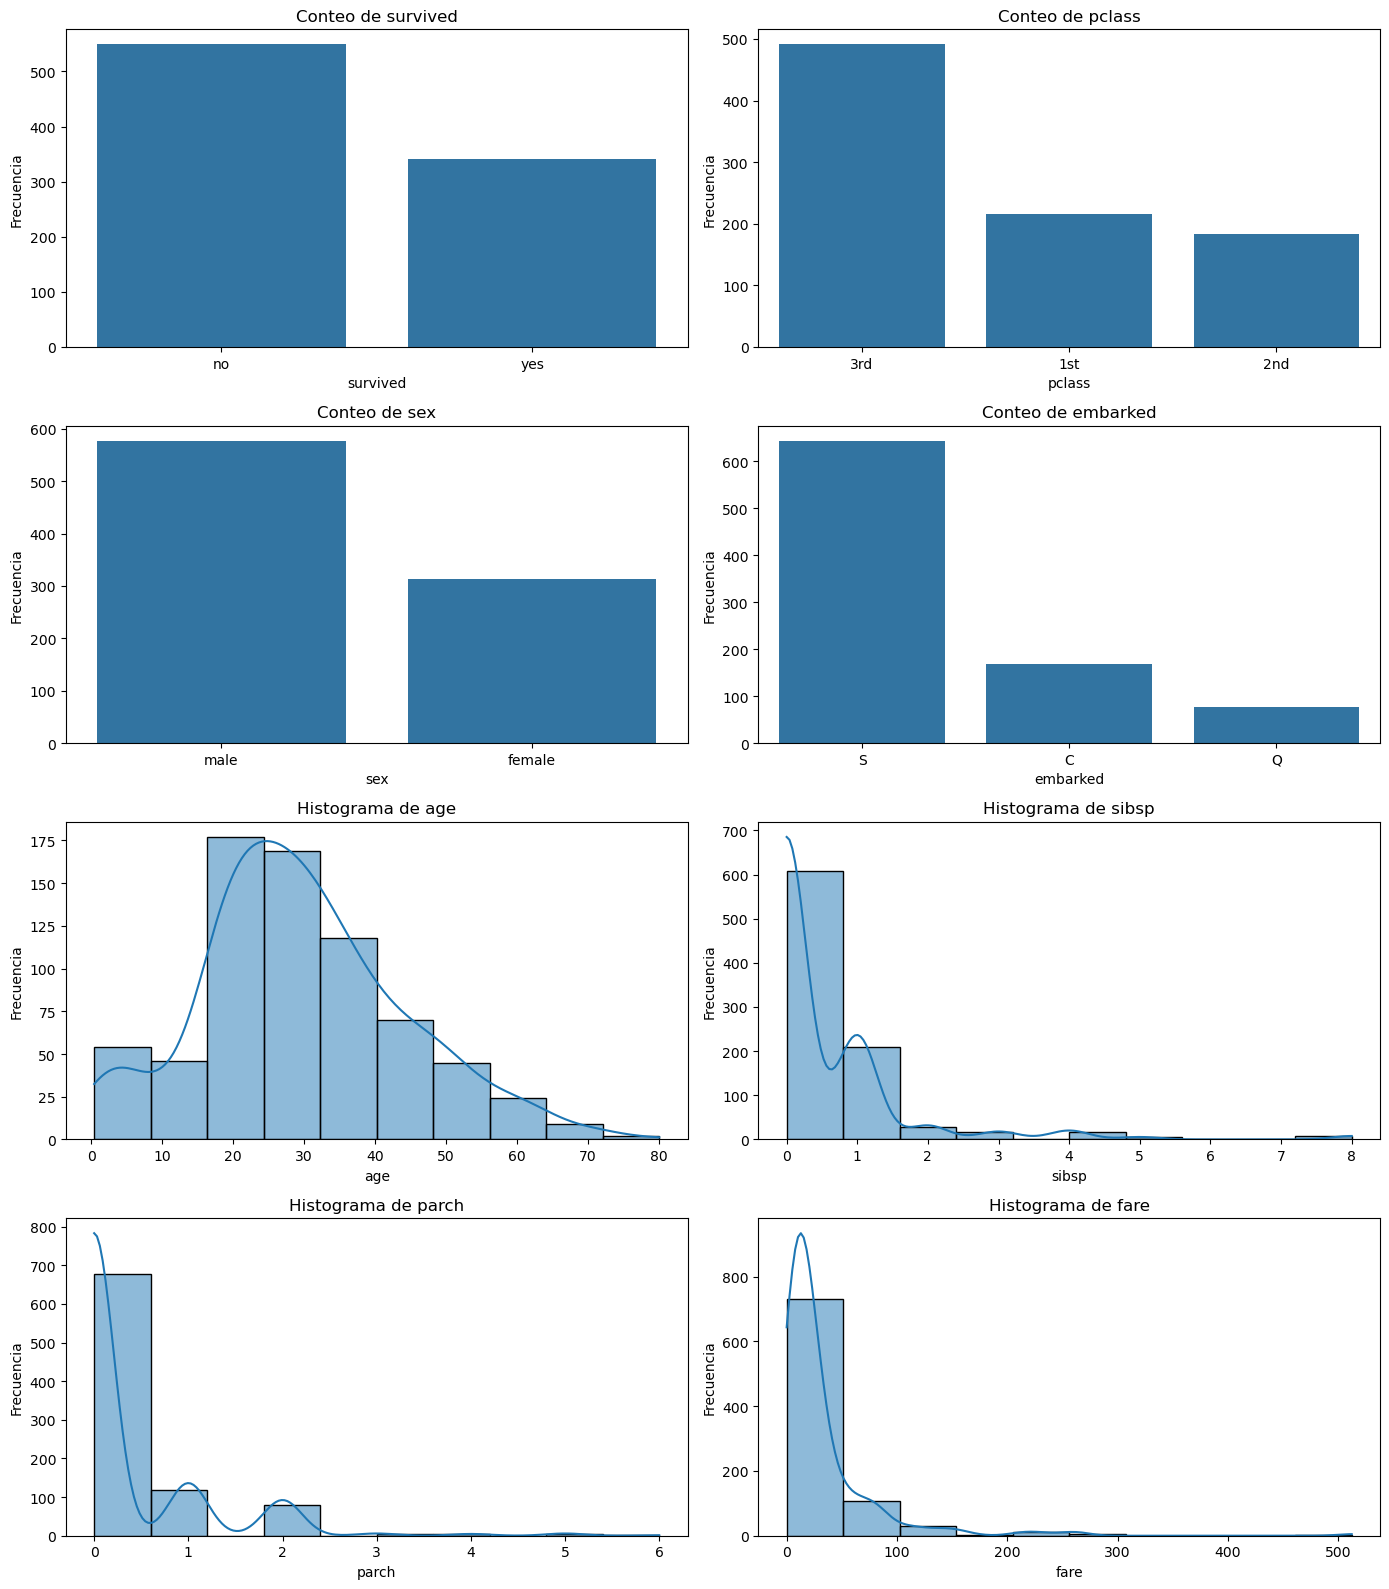

In [967]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hacemos una copia para visualizar los datos y no estropear la original
df_temp = df_titanic.copy()

#Transformamos el binario de survived
df_temp['survived'] = df_temp['survived'].map({0: 'no', 1: 'yes'})

#Transformamos el categorico de 3 opciones de pclass
df_temp['pclass'] = df_temp['pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})

# Seleccionar las columnas categóricas y numéricas
df_cat = df_temp.select_dtypes(include=['object', 'bool'])  # Columnas categóricas
df_num = df_temp.select_dtypes(include=['int64', 'float64'])  # Columnas numéricas

# Crear la cuadrícula de subplots 4x2
fig, axes = plt.subplots(4, 2, figsize=(14, 16))  # Tamaño de la figura ajustado
axes = axes.flatten()  # Aplanar el arreglo de ejes para un acceso más fácil

# Índice para los subplots
idx = 0

# Graficar las variables categóricas
for columna in df_cat.columns:
    if idx < len(axes):  # Verificar si el índice está dentro del rango de subplots
        sns.countplot(data=df_temp, x=columna, ax=axes[idx])
        axes[idx].set_title(f'Conteo de {columna}')
        axes[idx].set_xlabel(columna)
        axes[idx].set_ylabel('Frecuencia')
        idx += 1

# Graficar las variables numéricas
for columna in df_num.columns:
    if idx < len(axes):  # Verificar si el índice está dentro del rango de subplots
        sns.histplot(data=df_temp, x=columna, bins=10, kde=True, ax=axes[idx])
        axes[idx].set_title(f'Histograma de {columna}')
        axes[idx].set_xlabel(columna)
        axes[idx].set_ylabel('Frecuencia')
        idx += 1

# Eliminar cualquier subplot no utilizado
for j in range(idx, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

¿A la vista de los datos que conclusiones puedes sacar?

In [968]:
# El ratio hombre a mujer era de 2:1 más o menos, es probable que casi ninguna mujer viajase sola
# La mayoria de tripulantes embarcaron en el puerto S, parece el comienzo del recorrido y tendrá parcialidad debido a contar a la tripulación
# Survived y pclass son categoricos, hay que transformarlos, pero se extrae que más de la mitad de los pasajeros murieron y que la clase más poblada era la 3ra
# La media de edad era de 25 aproximadamente
# No era común viajar con hermanos o conyujes segun sbisp
# En parch se muestran grupos de gente viajando con 1 o 2 hijos o con sus 2 padres y tambien mucha gente viajando sin familia no conyuje
# La tarifa de embarque tiene algunos billetes de lujo sueltos

Muestra la media de supervivientes según el la clase de billete ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [969]:
# Calcular la media de supervivientes por clase de billete
media_supervivencia_por_clase = df_titanic.groupby('pclass')['survived'].mean().sort_values(ascending=False).reset_index()

# Renombrar las columnas
media_supervivencia_por_clase.columns = ['Clase', 'Media de Supervivencia']

print(media_supervivencia_por_clase)

   Clase  Media de Supervivencia
0      1                0.629630
1      2                0.472826
2      3                0.242363


In [970]:
# Hay una corelacion directa entre la clase y el ratio de supervivencia
# puede que sea por donde estaban las cabinas de la 3ra clase o porque se les dio prioridad a los de
# primera clase

Muestra la media de supervivientes según el sexo ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [971]:
# Calcular la media de supervivientes por sexo
media_supervivencia_por_sexo = df_titanic.groupby('sex')['survived'].mean().sort_values(ascending=False).reset_index()

# Renombrar las columnas
media_supervivencia_por_sexo.columns = ['Sexo', 'Media de Supervivencia']

print(media_supervivencia_por_sexo)

     Sexo  Media de Supervivencia
0  female                0.742038
1    male                0.188908


In [972]:
# El lema de "Las mujeres primero" pareció cumplirse. Tambien era esperado sabiendo que el ratio del
# genero de los pasajeros era 2 hombres por mujer

Muestra la media de supervivientes según el número de hermanos y coyúnges ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [973]:
# Calcular la media de supervivientes según el número de hermanos/cónyuges
media_supervivencia_por_sibsp = df_titanic.groupby('sibsp')['survived'].mean().sort_values(ascending=False).reset_index()

# Renombrar las columnas para mayor claridad
media_supervivencia_por_sibsp.columns = ['Hermanos/Cónyuges', 'Media de Supervivencia']

print(media_supervivencia_por_sibsp)

   Hermanos/Cónyuges  Media de Supervivencia
0                  1                0.535885
1                  2                0.464286
2                  0                0.345395
3                  3                0.250000
4                  4                0.166667
5                  5                0.000000
6                  8                0.000000


In [974]:
# Tener 1 o 2 familiares a bordo pareció ayudar en la supervivencia

Muestra la media de supervivientes según el número de padres e hijos ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [975]:
# Calcular la media de supervivientes según el número de padres/hijos
media_supervivencia_por_parch = df_titanic.groupby('parch')['survived'].mean().sort_values(ascending=False).reset_index()

# Renombrar las columnas para mayor claridad
media_supervivencia_por_parch.columns = ['Padres/Hijos', 'Media de Supervivencia']

print(media_supervivencia_por_parch)

   Padres/Hijos  Media de Supervivencia
0             3                0.600000
1             1                0.550847
2             2                0.500000
3             0                0.343658
4             5                0.200000
5             4                0.000000
6             6                0.000000


In [976]:
# Parece que tener hijos o ser padre ayudó a sobrevivir, puede que madres con sus hijos fueran priorizadas

Halla las correlaciones de los datos numéricos y muestra el coeficiente de correlacion de las diferentes variables respecto a la variable survived

In [977]:
# Filtramos solo numericos
corr_matrix = df_titanic.corr(numeric_only=True)

#Sacamos los valores de la matriz ordenados según survived
corr_matrix["survived"].sort_values(ascending=False)

survived    1.000000
fare        0.257307
parch       0.081629
sibsp      -0.035322
age        -0.077221
pclass     -0.338481
Name: survived, dtype: float64

Representa la matriz de correlaciones (representa directamente la matriz usando el stilo background_gradient)

In [978]:
corr_matrix.style.background_gradient()

,survived,pclass,age,sibsp,parch,fare
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


¿Qué conclusiones sacas de la matriz de correlaciones?

In [979]:
# Las columnas que más an afectado al ratio de supervivencia son la clase y el precio del ticket
# El precio del ticket está fuertemente correlacionado con la clase también, podemos fijarnos en pclass directamente

Vamos a seguir explorando los datos haciendo algún gráfico más:

- Grafico de barras para representar el número de supervivientes según la clase de billete y por sexos

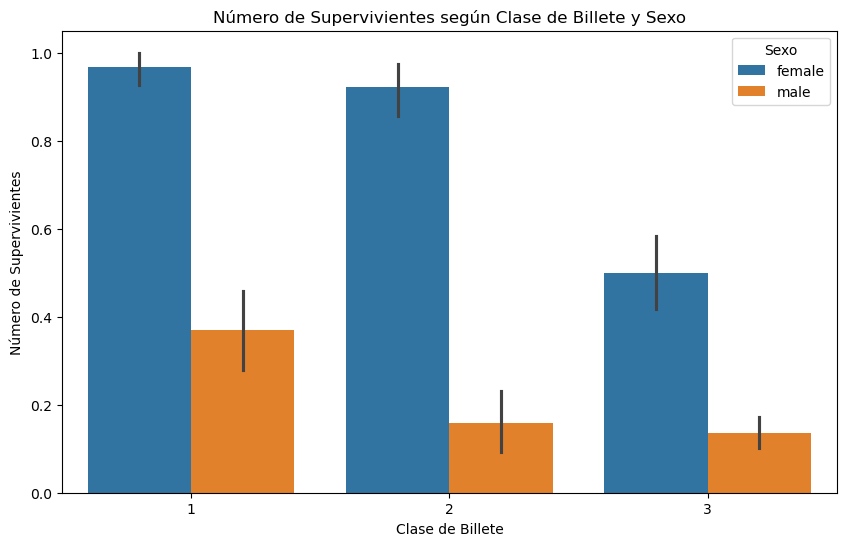

In [980]:
# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_titanic, x='pclass', y='survived', hue='sex')

# Añadir títulos y etiquetas
plt.title('Número de Supervivientes según Clase de Billete y Sexo')
plt.xlabel('Clase de Billete')
plt.ylabel('Número de Supervivientes')
plt.legend(title='Sexo')

# Mostrar el gráfico
plt.show()

- Usando FaceGird de seaborn representa los supervivientes según la clase de billete y el puerto de embarque

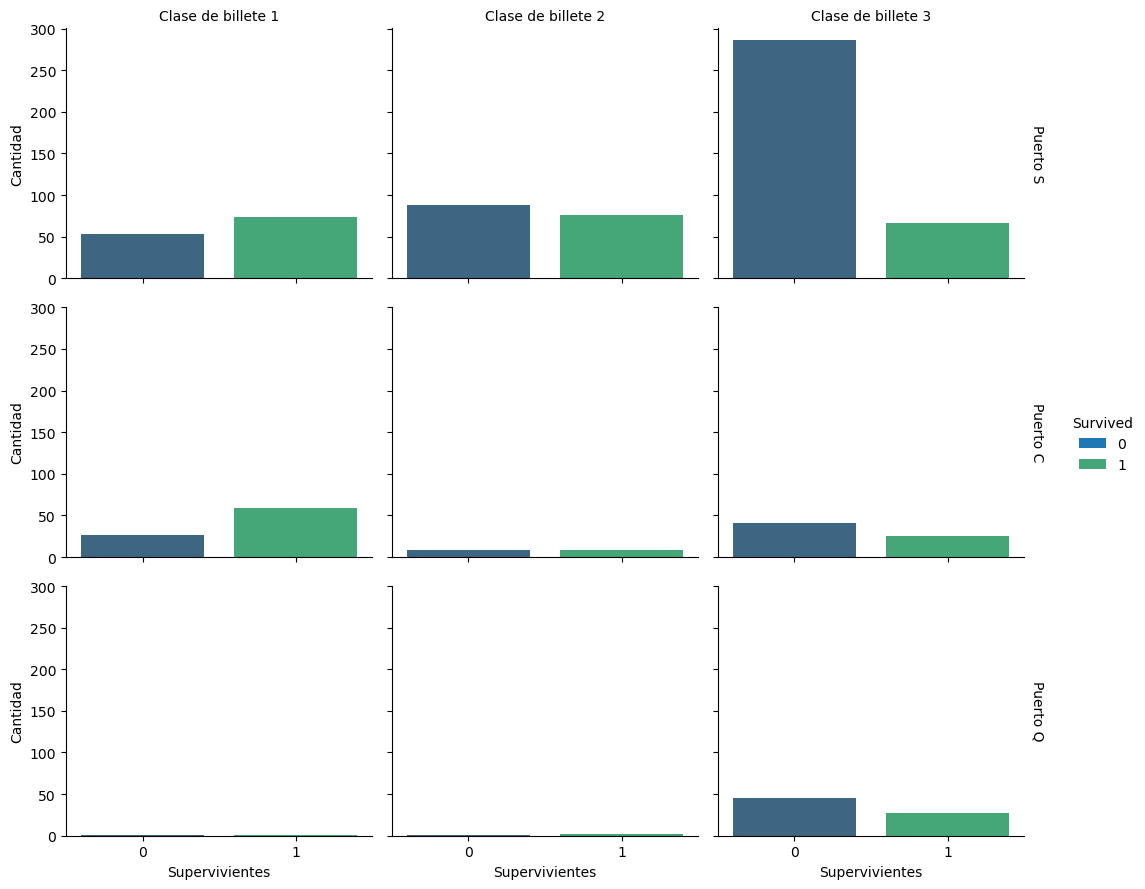

In [981]:
# Crear un FacetGrid para mostrar la supervivencia según clase de billete y puerto de embarque
g = sns.FacetGrid(df_titanic, col="pclass", row="embarked", hue="survived", margin_titles=True, height=3, aspect=1.2)

# Dibujar un gráfico de conteo
g.map(sns.countplot, "survived", order=[0, 1], palette="viridis")

# Agregar leyendas y ajustar la visualización
g.add_legend(title="Survived")
g.set_axis_labels("Supervivientes", "Cantidad")
g.set_titles(col_template="Clase de billete {col_name}", row_template="Puerto {row_name}")
plt.show()

### DIVIDIR LOS DATOS

Es hora de separar el conjunto de entrenamiento del conjunto de prueba (85% para el entrenamiento y haciendo un muestreo estratificado según la clase del billete, que parece que es una de las más correlacionada con la carracteristica survived y hay bastante más pasajeros de clase 3 que de clase 1 y2).

In [982]:
train_set, test_set = train_test_split(df_titanic, test_size=0.15, stratify=df_titanic["pclass"], random_state=3)

Haz una copia del conjunto de entrenamiento para trabajar con él.

In [983]:
my_train_set = train_set.copy()

### PREPARAR LOS DATOS

Hay que crear un pipeline de transformación que haga los siguientes cambios:
- pclass: 
  - rellenar datos faltantes con la moda
- sex:
  - rellenar datos faltantes con la moda
  - convertir male a 0 y female a 1
- age:
  - rellenar datos faltantes con la media
  - convertirla en variable categórica:
      - 1 - <=16
      - 2 - (16,32]
      - 3 - (32,48]
      - 4 - (48,64]
      - 5 - >64)
- family = sibsp + parch
  - rellenar datos faltantes con la moda
  - sumar las dos columnas
- fare
  - rellenar datos faltantes con la media
  - aplicar raiz cuadrada
  - estandarizar
- embarked
  - rellenar datos faltantes con la moda
  - aplicar one-hot

Pero vamos a empezar poco a poco

Crea el atributo familia como suma de sibsp y parch y luego borra sibsp y parch

In [984]:
my_train_set["family"] = my_train_set["sibsp"] + my_train_set["parch"]
my_train_set = my_train_set.drop("sibsp", axis=1)
my_train_set = my_train_set.drop("parch", axis=1)
df_titanic.info()
my_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 757 entries, 820 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  757 non-null    int64  
 1   pclass    757 non-null    int64  
 2   sex       757 non-null    object 
 3   age       600 non-null    float64
 4   fare      757 non-null    float64
 5   embarked  755 non-null    object 
 6   family    757 non-null   

Rellenamos los datos ausentes en el dataframe (lo hacemos para todas las columnas aunque ahora la mayoría no tiene datos ausentes, pero no sabemos como serán los datos si tenemos que volver a entrenar el modelo)

In [985]:
# Filtrar solo las columnas numéricas
numeric_cols = my_train_set.select_dtypes(include=['number']).columns

# Aplicar SimpleImputer con la estrategia 'most_frequent'
imputer = SimpleImputer(strategy='most_frequent')
my_train_set[numeric_cols] = imputer.fit_transform(my_train_set[numeric_cols])

my_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 757 entries, 820 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  757 non-null    float64
 1   pclass    757 non-null    float64
 2   sex       757 non-null    object 
 3   age       757 non-null    float64
 4   fare      757 non-null    float64
 5   embarked  755 non-null    object 
 6   family    757 non-null    float64
dtypes: float64(5), object(2)
memory usage: 47.3+ KB


En el columna sex sustituir male por 0 y female por 1

In [986]:
from sklearn.preprocessing import LabelEncoder

# Creamos el encoder
label_encoder = LabelEncoder()

# Se lo aplicamos a la columna sex
my_train_set['sex'] = label_encoder.fit_transform(my_train_set['sex'])

my_train_set.head()


,survived,pclass,sex,age,fare,embarked,family
820,1.0,1.0,0,52.0,93.5000,S,2.0
505,0.0,1.0,1,18.0,108.9000,C,1.0
447,1.0,1.0,1,34.0,26.5500,S,0.0
368,1.0,3.0,0,24.0,7.7500,Q,0.0
709,1.0,3.0,1,24.0,15.2458,C,2.0


Aplicar One-Hot a la columna embarked

In [987]:
# Inicializar el OneHotEncoder, quitando el puerto C, con dos columnas podemos marcar 3 posibilidades
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Aplicar el codificador a la columna embarked y transformar los datos
embarked_encoded = encoder.fit_transform(my_train_set[['embarked']])

# Crear un DataFrame con las columnas codificadas
embarked_df = pd.DataFrame(embarked_encoded, columns=encoder.get_feature_names_out(['embarked']))

# Concatenar las columnas codificadas al DataFrame original y eliminar la columna embarked
data_imputed = pd.concat([my_train_set.drop('embarked', axis=1), embarked_df], axis=1)

print(data_imputed.head())


     survived  pclass  sex   age      fare  family  embarked_Q  embarked_S  \
820       1.0     1.0  0.0  52.0   93.5000     2.0         NaN         NaN   
505       0.0     1.0  1.0  18.0  108.9000     1.0         0.0         1.0   
447       1.0     1.0  1.0  34.0   26.5500     0.0         1.0         0.0   
368       1.0     3.0  0.0  24.0    7.7500     0.0         0.0         1.0   
709       1.0     3.0  1.0  24.0   15.2458     2.0         0.0         1.0   

     embarked_nan  
820           NaN  
505           0.0  
447           0.0  
368           0.0  
709           0.0  


Convertir la variable age en una variable categórica: 
- 1 - <=16
- 2 - (16,32]
- 3 - (32,48]
- 4 - (48,64]
- 5 - >64)

In [988]:
my_train_set['age'] = pd.cut(my_train_set['age'], bins=[-1,16,32,48,64,100], labels=["1","2","3","4","5"], right=False)
my_train_set['age'].unique()

['4', '2', '3', '5', '1']
Categories (5, object): ['1' < '2' < '3' < '4' < '5']

Como la columna fare tiene una cola larga por la derecha y tiene valores que son cero aplica la raiz cuadrada a la variable

In [989]:
my_train_set["fare"] = np.sqrt(my_train_set["fare"])
df_titanic["fare"].describe()
my_train_set["fare"].describe()

count    757.000000
mean       4.847798
std        2.925359
min        0.000000
25%        2.815138
50%        3.801868
75%        5.540379
max       22.634690
Name: fare, dtype: float64

Estandarizar la variable fare

In [990]:
from sklearn.preprocessing import StandardScaler
# Inicializar el escalador
scaler = StandardScaler()
# Básicamente hace (el valor - la media) / la desviación estándar
my_train_set['fare'] = scaler.fit_transform(my_train_set[['fare']])
my_train_set['fare'].describe()

count    7.570000e+02
mean    -3.050547e-17
std      1.000661e+00
min     -1.658259e+00
25%     -6.953006e-01
50%     -3.577753e-01
75%      2.369075e-01
max      6.084263e+00
Name: fare, dtype: float64

Ya esta el dataframe con los datos de entrenamiento preparados, pero los cambios hechos también hay que hacerlos en los datps de prueba a y en un futuro en otros dataframe bien para entrenar de nuevo el modelo, bien para predecir datos. Por lo tanto, hay que crear una pipeline a la que le pasamos el dataframe y haga todos los cambios.

In [991]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Imputar los valores faltantes en 'embarked'
embarked_imputer = SimpleImputer(strategy='most_frequent')
train_set['embarked'] = embarked_imputer.fit_transform(train_set[['embarked']]).ravel()
test_set['embarked'] = embarked_imputer.transform(test_set[['embarked']]).ravel()

# Pipeline para procesar la tarifa
fare_pipeline = make_pipeline(
    FunctionTransformer(np.sqrt, feature_names_out="one-to-one"),
    StandardScaler()
)

# Funcion para los feature_names_out de age
def age_name(function_transformer, feature_names_in):
    return ["age"]  # feature names out

# Funcion para los feature_names_out de age
def family_name(function_transformer, feature_names_in):
    return ["family"]  # feature names out

# Función para categorizar edades
def categorize_age(X):
    imputer = SimpleImputer(strategy='most_frequent',)
    X_imputed = imputer.fit_transform(X)
    return pd.cut(X_imputed.flatten(), bins=[-1, 16, 32, 48, 64, np.inf], labels=[1, 2, 3, 4, 5]).to_numpy().reshape(-1, 1)

# Función para transformar tamaño de familia
def transform_family(X):
    return (X['sibsp'] + X['parch']).values.reshape(-1, 1)

# Combinación de transformadores
preprocessing = ColumnTransformer([
        ("sex", OneHotEncoder(drop='first'), ["sex"]),
        ("age", FunctionTransformer(categorize_age,feature_names_out=age_name, validate=False), ["age"]),
        ("family", FunctionTransformer(transform_family,feature_names_out=family_name,validate=False), ["sibsp", "parch"]),
        ("fare", fare_pipeline, ["fare"]),
        ("embarked", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ["embarked"])  # Renombrado para evitar colisión
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Aplicar la transformación solo en train_set
prep_array_train = preprocessing.fit_transform(train_set)

# Aplicar la transformación en test_set (sin ajustar)
prep_array_test = preprocessing.transform(test_set)

# Lo hago a mano
feature_names = preprocessing.get_feature_names_out()

# Convertir a DataFrame y asignar nombres de columnas automáticamente
train_set = pd.DataFrame(prep_array_train, columns=feature_names)
test_set = pd.DataFrame(prep_array_test, columns=feature_names)

print(train_set.head())
print(test_set.head())


   sex_male  age  family      fare  embarked_C  embarked_Q  embarked_S  \
0       0.0  4.0     2.0  1.649346         0.0         0.0         1.0   
1       1.0  2.0     1.0  1.911360         1.0         0.0         0.0   
2       1.0  3.0     0.0  0.104286         0.0         0.0         1.0   
3       0.0  2.0     0.0 -0.705992         0.0         1.0         0.0   
4       1.0  2.0     2.0 -0.322639         1.0         0.0         0.0   

   survived  pclass  
0       1.0     1.0  
1       0.0     1.0  
2       1.0     1.0  
3       1.0     3.0  
4       1.0     3.0  
   sex_male  age  family      fare  embarked_C  embarked_Q  embarked_S  \
0       0.0  2.0     2.0 -0.322639         1.0         0.0         0.0   
1       1.0  2.0     0.0 -0.687736         0.0         0.0         1.0   
2       1.0  2.0     0.0  0.365421         0.0         0.0         1.0   
3       0.0  3.0     1.0  0.899230         0.0         0.0         1.0   
4       1.0  2.0     0.0 -0.703182         0.0       

## ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Vamos a probar varios algoritmos para ver cual es el que mejor va, para ello primero vamos a evaluarlos manualmente y luego ya utilizaremos validación cruzada.

En concreto vamos a probar:
- Regresión logística
- Random Forest
- KNN (K - Nearest Neighbors)

Cuanto más se acerque a 1 la exactitud (accuracy), mejor será el modelo.

### REGRESIÓN LOGÍSTICA
Pasos a seguir:
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de entrenamiento
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de test
- Crear el modelo (modelo = LogisticRegression())
- Entrenar el modelo
- Calcular la precisión para el conjunto de entrenamiento (usa accuracy_score)
- Calcular la precisión para el conjunto de test 

In [999]:
# Separar X (características) y y (columna objetivo) del conjunto de entrenamiento
x_train = train_set.drop('survived', axis=1)
y_train = train_set['survived']

# Separar X (características) y y (columna objetivo) del conjunto de test
x_test = test_set.drop('survived', axis=1)
y_test = test_set['survived']

# Crear el modelo de regresión logística
modelo = LogisticRegression()

# Entrenar el modelo
modelo.fit(x_train, y_train)

# Predecir en el conjunto de entrenamiento
y_train_pred = modelo.predict(x_train)

# Predecir en el conjunto de prueba
y_test_pred = modelo.predict(x_test)

# Calcular la precisión
train_accuracy_reg = accuracy_score(y_train, y_train_pred)
test_accuracy_reg = accuracy_score(y_test, y_test_pred)

# Mostrar resultados
print(f'Precisión en el conjunto de entrenamiento: {train_accuracy_reg:.2f}')
print(f'Precisión en el conjunto de prueba: {test_accuracy_reg:.2f}')


Precisión en el conjunto de entrenamiento: 0.81
Precisión en el conjunto de prueba: 0.78


### RANDOM FOREST
Hacemos lo mismo pero ahora usando el algoritmo Random Forest (RandomForestClassifier(n_estimators=100))

In [1000]:
# Separar X (características) y y (columna objetivo) del conjunto de entrenamiento
x_train = train_set.drop('survived', axis=1)
y_train = train_set['survived']

# Separar X (características) y y (columna objetivo) del conjunto de test
x_test = test_set.drop('survived', axis=1)
y_test = test_set['survived']

# Crear el modelo de regresión logística
modelo = RandomForestClassifier(n_estimators=100)

# Entrenar el modelo
modelo.fit(x_train, y_train)

# Predecir en el conjunto de entrenamiento
y_train_pred = modelo.predict(x_train)

# Predecir en el conjunto de prueba
y_test_pred = modelo.predict(x_test)

# Calcular la precisión
train_accuracy_rand = accuracy_score(y_train, y_train_pred)
test_accuracy_rand = accuracy_score(y_test, y_test_pred)

# Mostrar resultados
print(f'Precisión en el conjunto de entrenamiento: {train_accuracy_reg:.2f}')
print(f'Precisión en el conjunto de prueba: {test_accuracy_reg:.2f}')

Precisión en el conjunto de entrenamiento: 0.81
Precisión en el conjunto de prueba: 0.78


### K - NEAREST NEIGHBORS
Hacemos lo mismo pero ahora usando el algoritmo K - Nearest Neighbours (KNeighborsClassifier(n_neighbors=3))

In [1001]:
# Separar X (características) y y (columna objetivo) del conjunto de entrenamiento
x_train = train_set.drop('survived', axis=1)
y_train = train_set['survived']

# Separar X (características) y y (columna objetivo) del conjunto de test
x_test = test_set.drop('survived', axis=1)
y_test = test_set['survived']

# Crear el modelo de regresión logística
modelo = KNeighborsClassifier(n_neighbors=3)

# Entrenar el modelo
modelo.fit(x_train, y_train)

# Predecir en el conjunto de entrenamiento
y_train_pred = modelo.predict(x_train)

# Predecir en el conjunto de prueba
y_test_pred = modelo.predict(x_test)

# Calcular la precisión
train_accuracy_k = accuracy_score(y_train, y_train_pred)
test_accuracy_k = accuracy_score(y_test, y_test_pred)

# Mostrar resultados
print(f'Precisión en el conjunto de entrenamiento: {train_accuracy_reg:.2f}')
print(f'Precisión en el conjunto de prueba: {test_accuracy_reg:.2f}')

Precisión en el conjunto de entrenamiento: 0.81
Precisión en el conjunto de prueba: 0.78


### COMPARACIÓN

Muestra una tablas con los resultado obtenidos


| Modelo                 |Precisión entrenamiento   | Precisión test  |
|------------------------|--------------------------|-----------------|
| LogisticRegression     |                          |                 |
| RandomForestClassifier |                          |                 |
| KNeighborsClassifier   |                          |                 |

In [1002]:
# Crear un DataFrame vacío con los nombres de los modelos
results = pd.DataFrame({
    "Modelo": ["LogisticRegression", "RandomForestClassifier", "KNeighborsClassifier"],
    "Precisión entrenamiento": [train_accuracy_reg, train_accuracy_rand, train_accuracy_k],
    "Precisión test": [test_accuracy_reg, test_accuracy_rand, test_accuracy_k]
})

# Mostrar la tabla
print(results)

                   Modelo  Precisión entrenamiento  Precisión test
0      LogisticRegression                 0.807133        0.776119
1  RandomForestClassifier                 0.945839        0.813433
2    KNeighborsClassifier                 0.878468        0.783582


A la vista de los resultados con ¿cual te quedas para trabajarlo con validación cruzada y luego optimizarlo?

In [367]:
# Con randomforest

Vamos a usar RandomForestClassifier con validación cruzada

In [368]:
from sklearn.metrics import make_scorer, mean_squared_error

# Calcular el RMSE usando validación cruzada
tree_rmses = -cross_val_score(modelo, X_processed, y, scoring="neg_root_mean_squared_error", cv=10)

# Mostrar el RMSE promedio
print(f'RMSE promedio a través de validación cruzada: {np.mean(tree_rmses):.2f}')


RMSE promedio a través de validación cruzada: 0.46


## OPTIMIZACIÓN DEL MODELO

Vamos a optimizar el modelo usando busqueda aleatorio para optimizar los hiperparametros, en concreto vamos a mejorar los siguientes hiperparametros
``````
param_dist = {
    'randomforestclassifier__n_estimators': randint(10, 200),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}
``````

In [369]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=3)),
])
param_grid = [
    {
        "random_forest__n_estimators": [50, 100, 200],
        "random_forest__max_features": [4, 6, 8, 10],
    }
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X, y)
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación (RMSE negativo):", -grid_search.best_score_)


Mejores parámetros: {'random_forest__max_features': 6, 'random_forest__n_estimators': 200}
Mejor puntuación (RMSE negativo): 0.3927008473679256


### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

EvaluaR el modelo usando accuracy_score y el conjunto de datos de test

In [370]:
df = df_titanic.copy()
X = df.drop('survived', axis=1) # Características
y = df['survived'] # Columna a predecir

# Dividir el conjunto en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Crear el pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestClassifier(n_estimators=200, max_features=6, random_state=3))
])

# Entrenar el modelo usando el pipeline
modelo = pipeline.fit(X_train, y_train)

# Predecir en el conjunto de prueba usando el pipeline
y_test_pred = pipeline.predict(X_test)

# Calcular la precisión
test_accuracy = accuracy_score(y_test, y_test_pred)

# Mostrar la precisión
print(f'Precisión en el conjunto de prueba: {test_accuracy:.2f}')


Precisión en el conjunto de prueba: 0.79


## PRESENTACIÓN DE LA SOLUCIÓN

Ahora tienes que crear un archivo .py con todo lo necesario para que ejecute el modelo que acabamos de crear, en concreto el script tiene que ejecutar lo siguiente:
- Pedir un csv para predecir los datos (suponemos que los datos en el csv están bien)
- Cargamos los datos del csv en un dataframe.
- Aplicamos nuestro modelo al dataframe.
- Informamos al usuario de las predicciones.

In [373]:
from joblib import dump
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score
import joblib
import warnings

df_titanic = sns.load_dataset('titanic')
df_titanic.drop(columns=["class","who","adult_male","deck","embark_town","alive","alone"], inplace=True)

# Clase para codificar el sexo
class SexEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.le = LabelEncoder()
        self.le.fit(X.to_numpy().ravel())  # Necesario array 1D
        return self

    def transform(self, X):
        return self.le.transform(X.values.ravel()).reshape(-1, 1)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(['sex_encoded'])  # Devuelve nombre columna

# Clase para procesar la edad
class AgeEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy='most_frequent')  # Rellenar valores faltantes con la moda
        self.imputer.fit(X)  # Ajustar el imputador
        return self

    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        # Categorizamos las edades en grupos
        age_bins = [0, 16, 32, 48, 64, np.inf]  # Definir los límites de los grupos
        age_labels = [1, 2, 3, 4, 5]  # Etiquetas para los grupos
        return pd.cut(X_imputed.flatten(), bins=age_bins, labels=age_labels).to_numpy().reshape(-1, 1)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(['age_encoded'])

# Clase para crear la columna 'family'
class FamilySizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy='most_frequent')  # Rellenar valores faltantes con la moda
        self.imputer.fit(X)  # Ajustar el imputador
        return self

    def transform(self, X):
        return (X['sibsp'] + X['parch']).to_numpy().reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return np.array(['family_transformed'])  # Nombre de la nueva columna

# Clase para procesar el puerto de embarque
class EmbarkedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')  # Rellenar valores faltantes con la moda
        self.encoder = OneHotEncoder(sparse_output=False)  # Configuración para obtener un array denso

    def fit(self, X, y=None):
        # Ajustar el imputador a los datos
        self.imputer.fit(X)
        # Ajustar el codificador a los datos imputados
        X_imputed = self.imputer.transform(X)
        self.encoder.fit(X_imputed)
        return self

    def transform(self, X):
        # Rellenar valores faltantes primero
        X_imputed = self.imputer.transform(X)
        # Transformar los datos
        transformed_data = self.encoder.transform(X_imputed)
        # Obtener los nombres de las columnas codificadas
        column_names = self.encoder.get_feature_names_out(input_features=X.columns)
        return pd.DataFrame(transformed_data, columns=column_names, index=X.index)

    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out()  # Obtener los nombres de las columnas codificadas
    
# Pipeline para procesar la tarifa
fare_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),  # Rellenar con la media
    FunctionTransformer(np.sqrt, feature_names_out="one-to-one"),  # Aplicar la raíz cuadrada
    StandardScaler()  # Estandarizar
)

# Combinación de transformadores
preprocessing = ColumnTransformer([
        ("pclass", SimpleImputer(strategy='most_frequent'), ["pclass"]),  # llena pclass con la moda
        ("sex", SexEncoder(), ["sex"]),  # transforma male = 0 y female = 1
        ("age", AgeEncoder(), ["age"]),  # categoriza age
        ("family", FamilySizeTransformer(), ["sibsp", "parch"]),  # junta en family a sibsp y parch
        ("fare", fare_pipeline, ["fare"]),  # hacer cambios a fare
        ("embarked", EmbarkedTransformer(), ["embarked"]),  # hacer cambios a fare
    ],
    remainder='passthrough')

df = df_titanic.copy()
X = df.drop('survived', axis=1)  # Características
y = df['survived']                # Etiqueta (columna a predecir)

# Dividir el conjunto en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Crear el pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('preprocessing', preprocessing),  # Aquí va tu preprocesador
    ('random_forest', RandomForestClassifier(n_estimators=200, max_features=6, random_state=42))
])

# Entrenar el modelo usando el pipeline
modelo = pipeline.fit(X_train, y_train)

# Predecir en el conjunto de prueba usando el pipeline
y_test_pred = pipeline.predict(X_test)

# Calcular la precisión
test_accuracy = accuracy_score(y_test, y_test_pred)

# Mostrar la precisión
print(f'Precisión en el conjunto de prueba: {test_accuracy:.2f}')
dump(modelo, 'modelo_random_forest.joblib')
# Usar script prueba_modelo.py

Precisión en el conjunto de prueba: 0.79


['modelo_random_forest.joblib']